Hunter Bennett | Glass Lab | Brain Aging Project

Before diving into deep analysis of samples we'll take a look at the crude clustering of our samples based on the peaks called for QC and IP efficiency estimation. This involves three main checks.
1. Comparing average tag counts and tag count variance for each sample.
2. Performing principal component analysis on each sample.
3. Performing clustering based in inter-sample pearson correlation

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat
from homer_preprocessing import read_annotated_peaks

In [7]:
dataDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/'
workingDirectory = '/home/h1bennet/brain_aging/results/00_PU1_H3K27Ac_QC/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Merge peaks generated for estimating IP Efficiency

In [3]:
%%bash
if [ ! -d ./merged_peaks/ ]; then mkdir ./merged_peaks; fi
mergePeaks ./peak_files/*variablewidth* > merged_peaks/all_peaks.txt

	Max distance to merge: direct overlap required (-d given)
	Merging peaks... 
	Comparing ./peak_files/03_mouse_BL6_M_9week_PU1_ChIP_H3K27ac_1_JOS_20190809_CTTGTA_variablewidth_peaks.tsv (16170 total) and ./peak_files/03_mouse_BL6_M_9week_PU1_ChIP_H3K27ac_1_JOS_20190809_CTTGTA_variablewidth_peaks.tsv (16170 total)
	Comparing ./peak_files/03_mouse_BL6_M_9week_PU1_ChIP_H3K27ac_1_JOS_20190809_CTTGTA_variablewidth_peaks.tsv (16170 total) and ./peak_files/05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_1_AL_20200925_AGGTTATA_CAGTTCCG_variablewidth_peaks.tsv (20628 total)
	Comparing ./peak_files/03_mouse_BL6_M_9week_PU1_ChIP_H3K27ac_1_JOS_20190809_CTTGTA_variablewidth_peaks.tsv (16170 total) and ./peak_files/05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_2_AL_20200925_TCTGTTGG_TCGAATGG_variablewidth_peaks.tsv (20454 total)
	Comparing ./peak_files/03_mouse_BL6_M_9week_PU1_ChIP_H3K27ac_1_JOS_20190809_CTTGTA_variablewidth_peaks.tsv (16170 total) and ./peak_files/05_mouse_MPSIIIAhet_M_4month_PU1_ChI

# Annotate peaks with tag counts

In [8]:
%%bash
# delete the existing script file
rm ./annotatePeaks_homer.sh
# create a script file
touch ./annotatePeaks_homer.sh

In [9]:
tagdirs_full = np.sort(glob.glob(dataDirectory+'*'))

with open('./annotatePeaks_homer.sh', 'w') as f:
    annotate_raw = ['annotatePeaks.pl', './merged_peaks/all_peaks.txt',
                    'mm10', '-size 1000', '-raw', '-d \\\n',
                    ' \\\n'.join(tagdirs_full), '>',
                    './merged_peaks/ann_raw_all_peaks.txt &\n\n']
    
    annotate_norm = ['annotatePeaks.pl', './merged_peaks/all_peaks.txt',
                     'mm10', '-size 1000', '-norm 1e7', '-d \\\n',
                     ' \\\n'.join(tagdirs_full), '>',
                     './merged_peaks/ann_norm_all_peaks.txt &\n\n']
    
    f.write(' '.join(annotate_raw))    
    f.write(' '.join(annotate_norm))
    
    f.close()

# Read in annotated peak file

In [12]:
# import annotation file
df, mat = read_annotated_peaks('./merged_peaks/ann_norm_all_peaks.txt')

# # try with dropped sample
# dropsamp = ['00_mouse_BL6_M_8week_PU1_ChIP_H3K27Ac_3_AL_20191226_GTAGAG_ds']

# df = df.drop(dropsamp, axis=1)
# mat = mat.drop(dropsamp, axis=1)

# quantile normalize data
mat_quant = quantile_normalize_df(mat)

In [13]:
mat.columns.tolist()

['/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/03_mouse_BL6_M_9week_PU1_ChIP_H3K27ac_1_JOS_20190809_CTTGTA',
 '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_1_AL_20200925_AGGTTATA_CAGTTCCG',
 '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_2_AL_20200925_TCTGTTGG_TCGAATGG',
 '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_3_AL_20201111_CTGCTTCC_GATAGATC',
 '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/06_mouse_MPSIIIAhet_M_P240_PU1_ChIP_H3K27ac_1_AL_20191226_ATTCCT',
 '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/06_mouse_MPSIIIAhet_M_P240_PU1_ChIP_H3K27ac_2D_JOS_20191122_CTTGTA',
 '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/06_mouse_MPSIIIAhet_M_P240_PU1_ChIP_H3K27ac_2_AL_20191122_CTTGTA',
 '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/07_mouse_BL6_M_23month_PU1_ChIP_H3K27ac_1_AL_20201121_ATGTAAGT_ACTCTATG',
 '/data/mm10/Brain_MPSIIIA/ChIP/H3K27

Filter low count peaks that alter our results.  
For this crude analysis we will simply require that at least two samples have a normalized tag count above a certain threshold.

In [14]:
thresh = 8

print(mat.shape[0], 'total peaks')
print('filtering low tag count peaks')
peaks = []
mat = mat.reindex(mat.index[(mat > thresh).sum(1) > 1])
mat = mat.dropna(how='all')
mat_quant = mat_quant.reindex(mat.index[(mat > thresh).sum(1) > 1])
mat_quant = mat_quant.dropna(how='all')
print(mat.shape[0], 'total peaks')

mat_distal = mat.reindex(df.loc[np.abs(df['Distance to TSS']) >= 3000.0].index.tolist())
mat_distal.dropna(inplace=True)

67231 total peaks
filtering low tag count peaks
47286 total peaks


# Make Summary Plots

In [15]:
if not os.path.isdir('./figures'):
    os.mkdir('./figures')

## Mean-Variance Plot

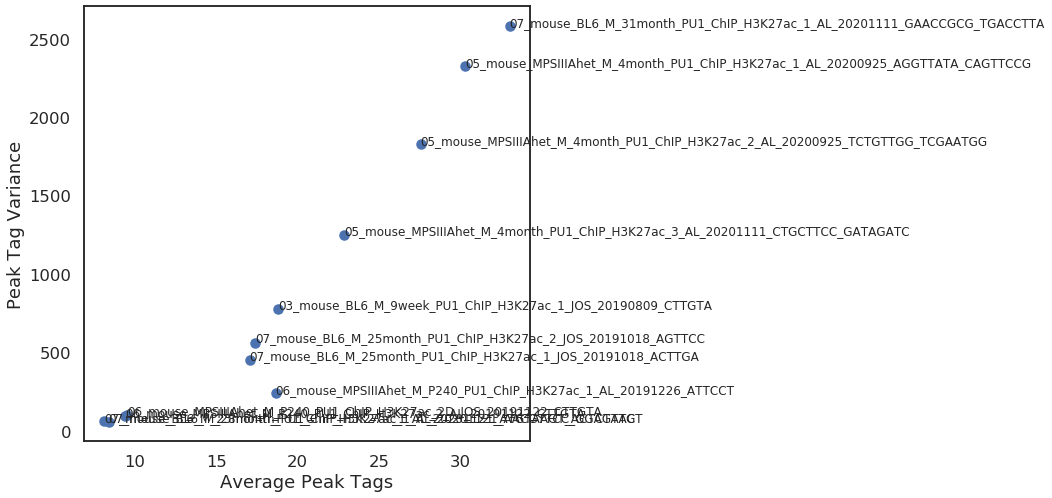

In [16]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(mat.mean(), mat.var())
plt.xlabel('Average Peak Tags')
plt.ylabel('Peak Tag Variance')
label_point(mat.mean(),
            mat.var(),
            mat.columns.str.split('/').str[-1],
            plt.gca())

plt.savefig('./figures/mean_variance_plot.png', bbox_inches='tight')

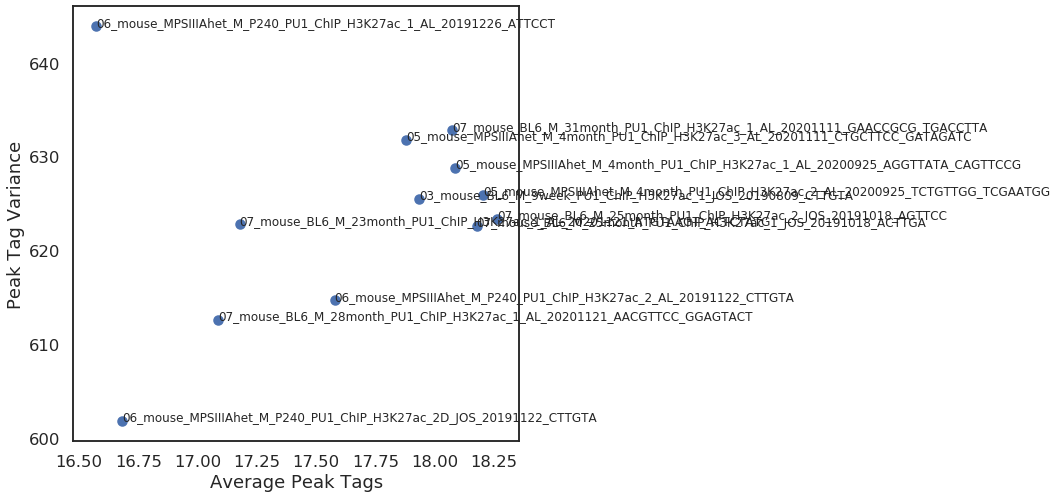

In [17]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(mat_quant.mean(), mat_quant.var())
plt.xlabel('Average Peak Tags')
plt.ylabel('Peak Tag Variance')
label_point(mat_quant.mean(),
            mat_quant.var(),
            mat_quant.columns.str.split('/').str[-1],
            plt.gca())

plt.savefig('./figures/mean_variance_plot_quantnorm.png', bbox_inches='tight')

## Sample correlation heatmap

In [18]:
mat.columns = mat.columns.str.split('/').str[-1]
mat_quant.columns = mat_quant.columns.str.split('/').str[-1]
mat_distal.columns = mat_distal.columns.str.split('/').str[-1]

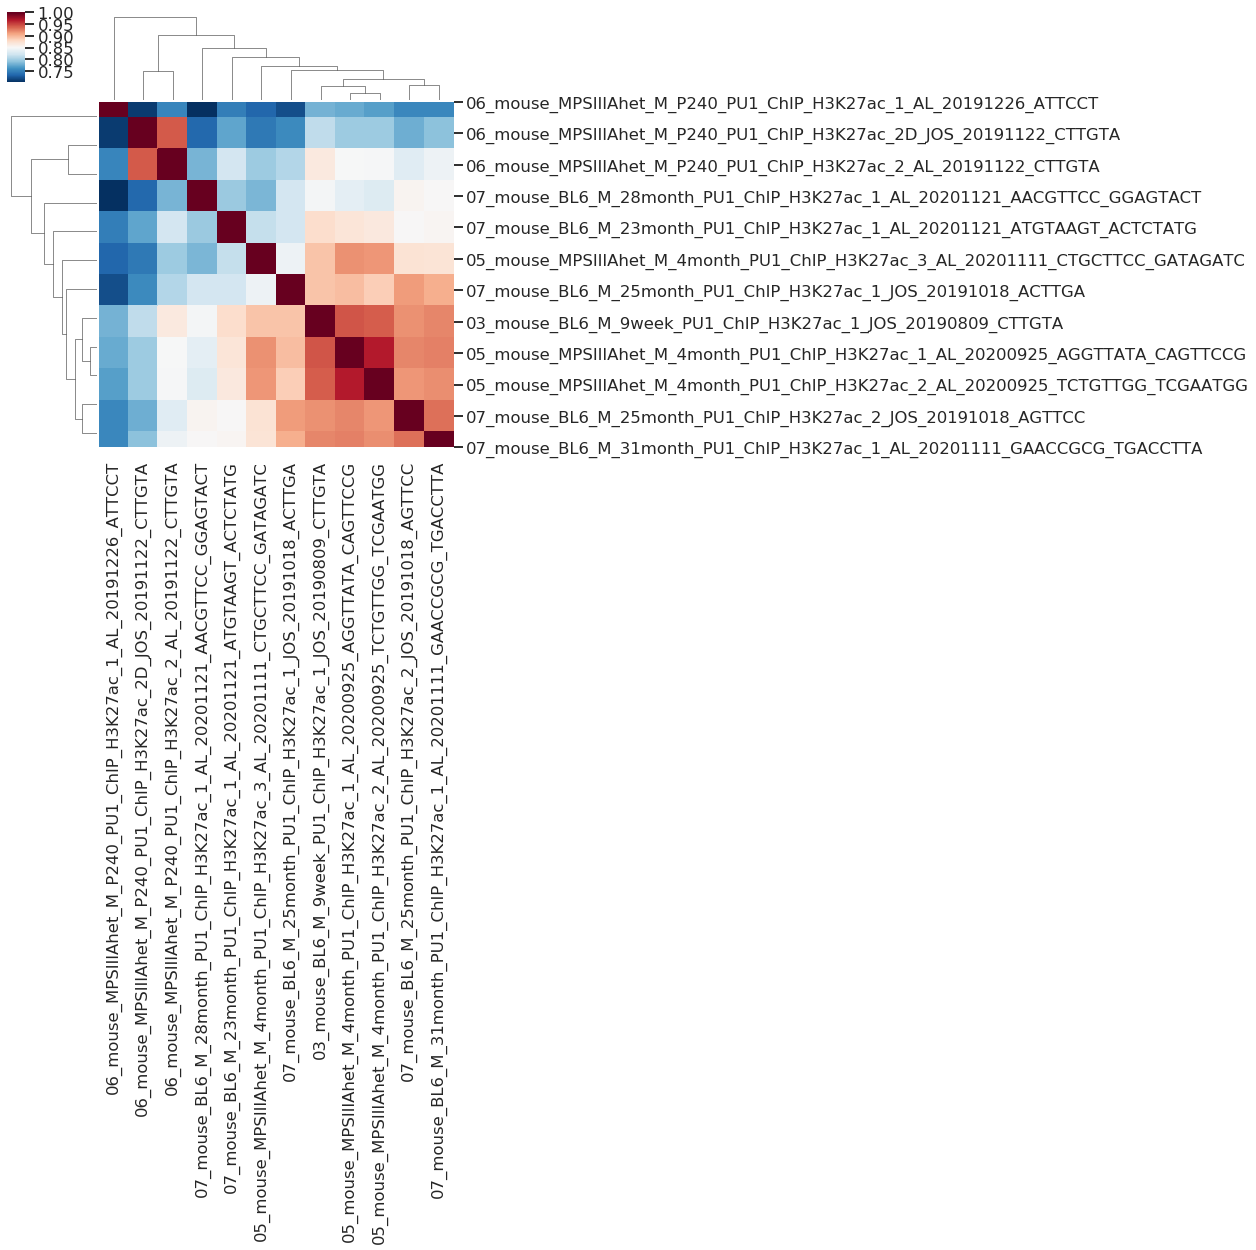

In [19]:
cm = sns.clustermap(
    mat.corr(),
    cmap='RdBu_r',
    figsize=(8,8))

# adjust y axis rotation
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

plt.savefig('./figures/h3k27ac_correlation_heatmap.png', bbox_inches='tight')

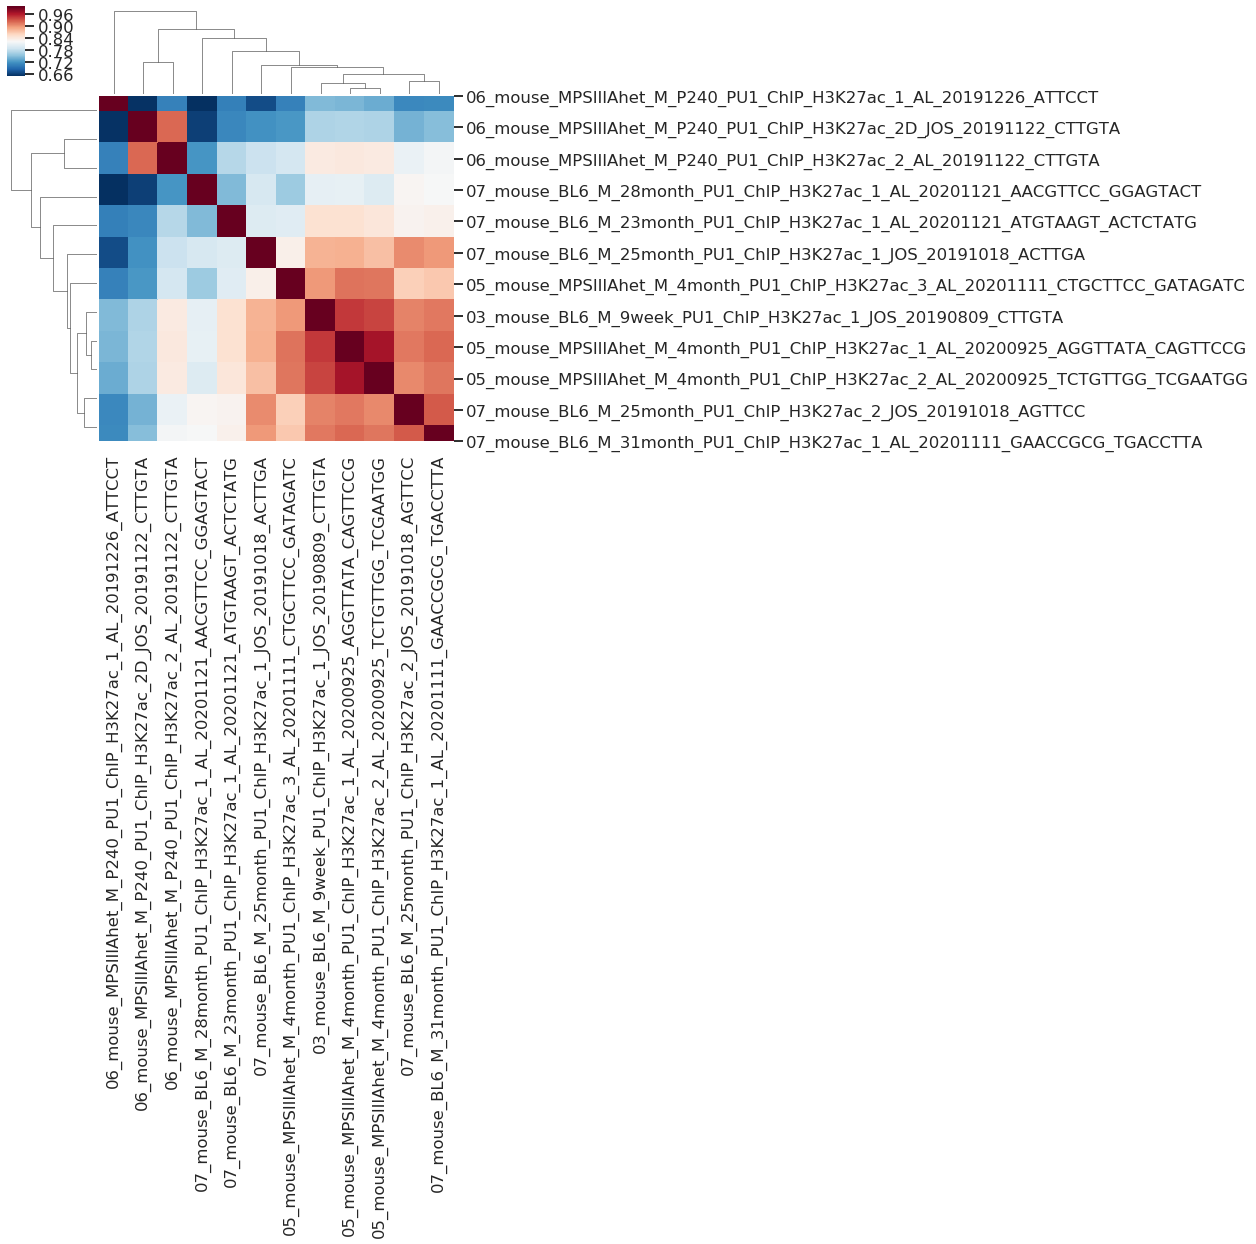

In [20]:
cm = sns.clustermap(
    mat_distal.corr(),
    cmap='RdBu_r',
    figsize=(8,8))

# adjust y axis rotation
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

plt.savefig('./figures/h3k27ac_correlation_heatmap_distal.png', bbox_inches='tight')

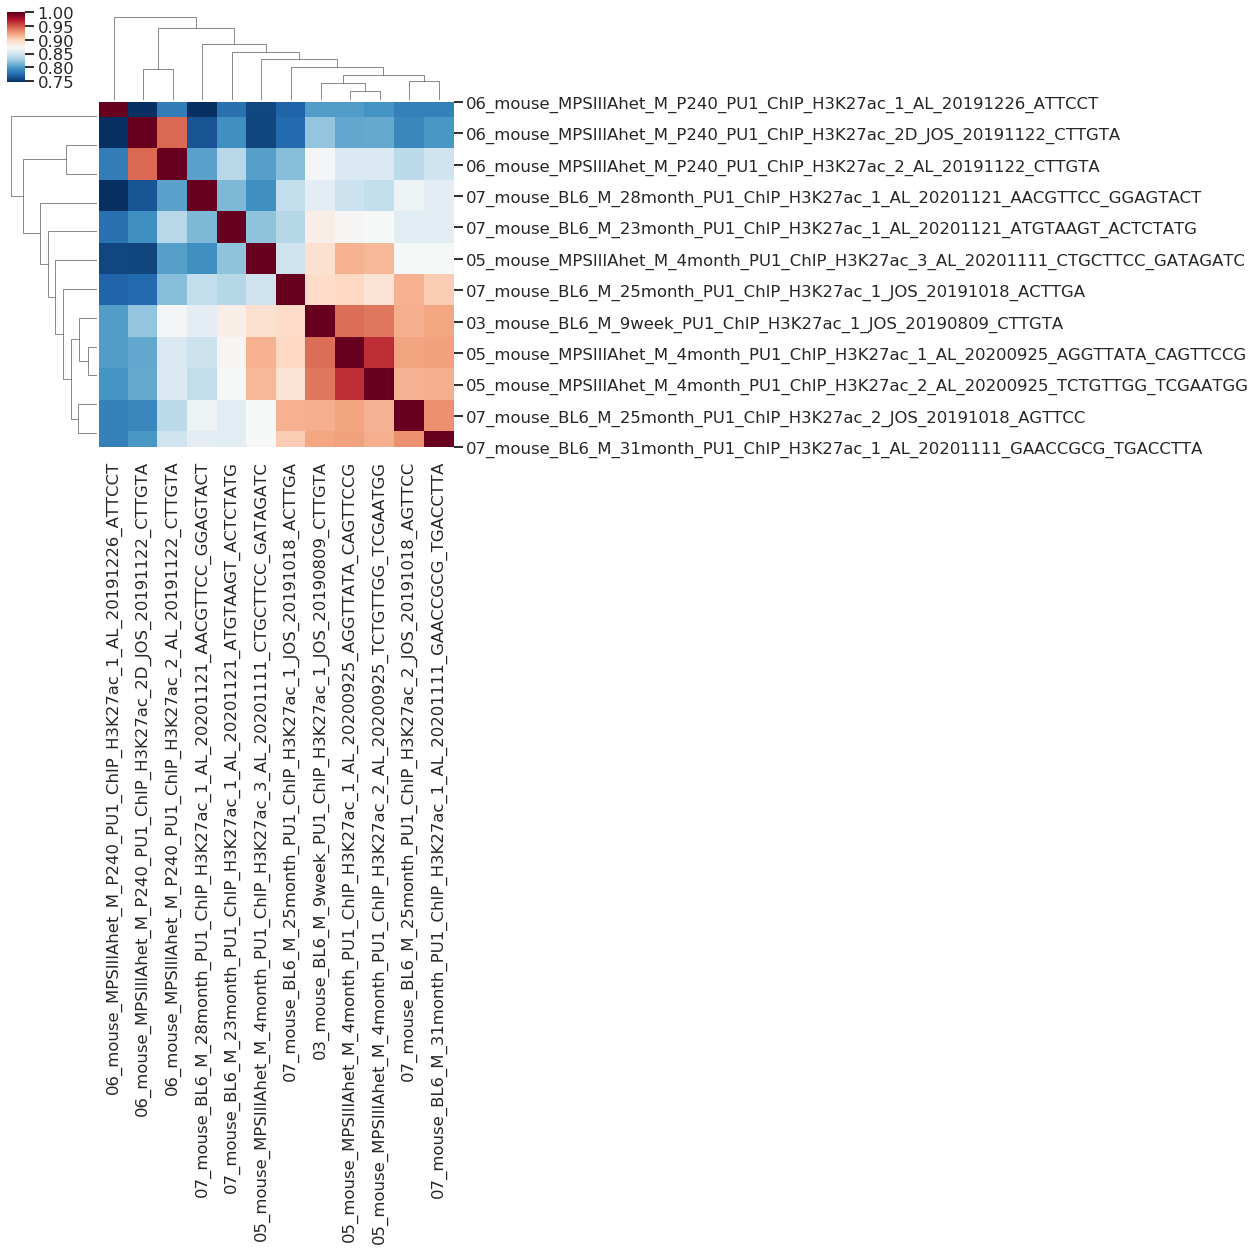

In [21]:
cm = sns.clustermap(
    mat_quant.corr(),
    cmap='RdBu_r',
    figsize=(8,8))

# adjust y axis rotation
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

plt.savefig('./figures/h3k27ac_correlation_heatmap_quantnorm.png', bbox_inches='tight')

## Principal component analysis

In [22]:
# this part must be done manually - use the sample ID fields to pick out
# identifiers for each sample.
samples = pd.Series(mat.columns)
group = samples.str.split('_').str[0]
strain = samples.str.split('_').str[2]
gender = samples.str.split('_').str[3]
age = samples.str.split('_').str[4]
cell = samples.str.split('_').str[5]
rep = samples.str.split('_').str[8]
sampledate = samples.str.split('_').str[9]
                                        
samplesDF = pd.DataFrame([pd.Series(samples),
                          pd.Series(group),
                          pd.Series(strain),
                          pd.Series(gender),
                          pd.Series(age),
                          pd.Series(cell),
                          pd.Series(rep),
                          pd.Series(sampledate)],
                         index=['mouse',
                                'group',
                                'strain',
                                'gender',
                                'age',
                                'celltype',
                                'rep',
                                'sample_date']).T

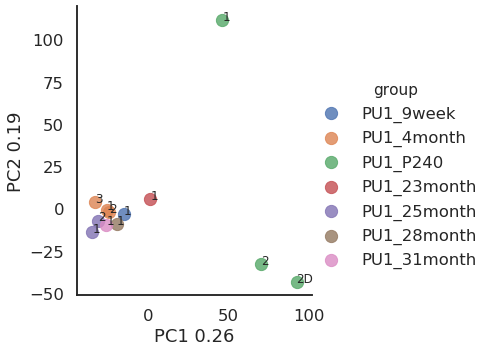

In [23]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat,
                                 group_labels=samplesDF.celltype+'_'+samplesDF.age,
                                 plot_size=5,
                                 n_pca=3)

label_point(pca.PC1,
            pca.PC2,
            samplesDF.rep,
            plt.gca())

plt.savefig('./figures/h3k27ac_pca1_pca2.png', bbox_inches='tight')

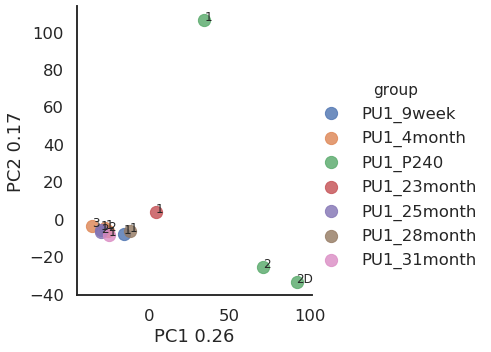

In [24]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat_quant,
                                 group_labels=samplesDF.celltype+'_'+samplesDF.age,
                                 plot_size=5,
                                 n_pca=3)

label_point(pca.PC1,
            pca.PC2,
            samplesDF.rep,
            plt.gca())

plt.savefig('./figures/h3k27ac_quantnorm_pca1_pca2.png', bbox_inches='tight')

# Next: filter samples that have poor QC and remake plots

In [36]:
# import annotation file
df, mat = read_annotated_peaks('./merged_peaks/ann_norm_all_peaks.txt')

# try with dropped sample
dropsamp = ['06_mouse_MPSIIIAhet_M_P240_PU1_ChIP_H3K27ac_2D_JOS_20191122_CTTGTA',
            '06_mouse_MPSIIIAhet_M_P240_PU1_ChIP_H3K27ac_2_AL_20191122_CTTGTA',
            '06_mouse_MPSIIIAhet_M_P240_PU1_ChIP_H3K27ac_1_AL_20191226_ATTCCT',
            '07_mouse_BL6_M_23month_PU1_ChIP_H3K27ac_1_AL_20201121_ATGTAAGT_ACTCTATG',
            '07_mouse_BL6_M_28month_PU1_ChIP_H3K27ac_1_AL_20201121_AACGTTCC_GGAGTACT']

dropcols = df.columns[df.columns.str.contains('|'.join(dropsamp))].tolist()

df = df.drop(columns=dropcols)
mat = mat.drop(columns=dropcols)

# quantile normalize data
mat_quant = quantile_normalize_df(mat)

Filter low count peaks that alter our results.  
For this crude analysis we will simply require that at least two samples have a normalized tag count above a certain threshold.

In [37]:
thresh = 8

print(mat.shape[0], 'total peaks')
print('filtering low tag count peaks')
peaks = []
mat = mat.reindex(mat.index[(mat > thresh).sum(1) > 1])
mat = mat.dropna(how='all')
mat_quant = mat_quant.reindex(mat.index[(mat > thresh).sum(1) > 1])
mat_quant = mat_quant.dropna(how='all')
print(mat.shape[0], 'total peaks')

mat_distal = mat.reindex(df.loc[np.abs(df['Distance to TSS']) >= 3000.0].index.tolist())
mat_distal.dropna(inplace=True)

67231 total peaks
filtering low tag count peaks
28666 total peaks


## Mean-Variance Plot

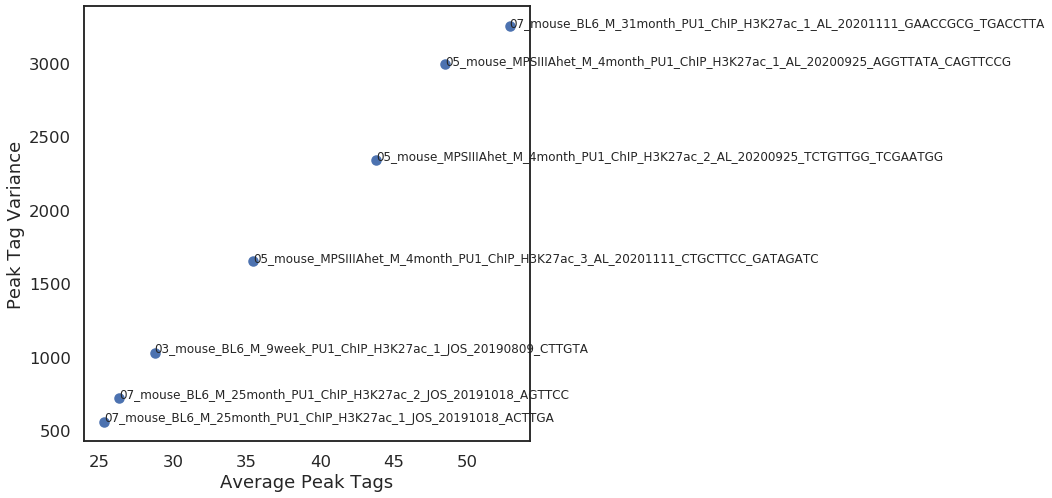

In [38]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(mat.mean(), mat.var())
plt.xlabel('Average Peak Tags')
plt.ylabel('Peak Tag Variance')
label_point(mat.mean(),
            mat.var(),
            mat.columns.str.split('/').str[-1],
            plt.gca())

plt.savefig('./figures/samp_filt_mean_variance_plot.png', bbox_inches='tight')

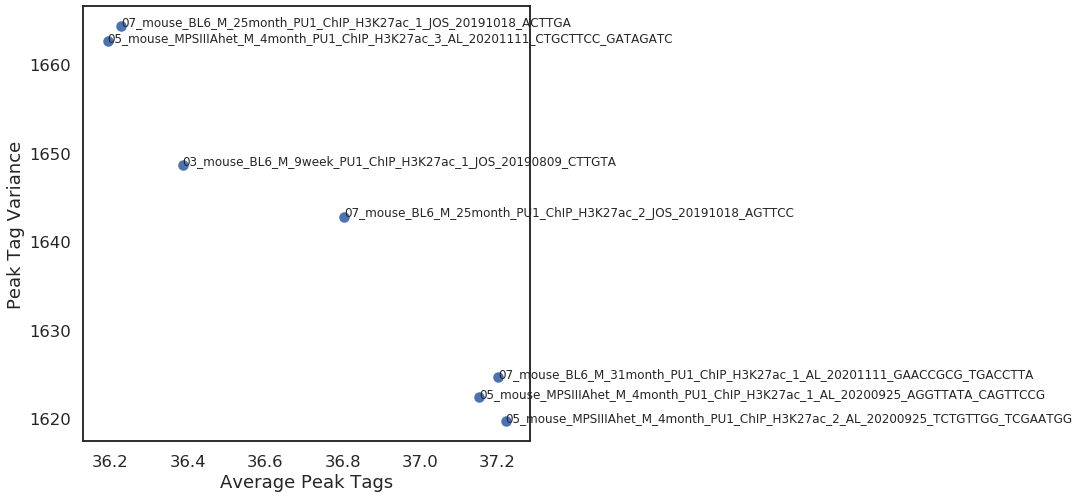

In [39]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(mat_quant.mean(), mat_quant.var())
plt.xlabel('Average Peak Tags')
plt.ylabel('Peak Tag Variance')
label_point(mat_quant.mean(),
            mat_quant.var(),
            mat_quant.columns.str.split('/').str[-1],
            plt.gca())

plt.savefig('./figures/samp_filt_mean_variance_plot_quantnorm.png', bbox_inches='tight')

## Sample correlation heatmap

In [40]:
mat.columns = mat.columns.str.split('/').str[-1]
mat_quant.columns = mat_quant.columns.str.split('/').str[-1]
mat_distal.columns = mat_distal.columns.str.split('/').str[-1]

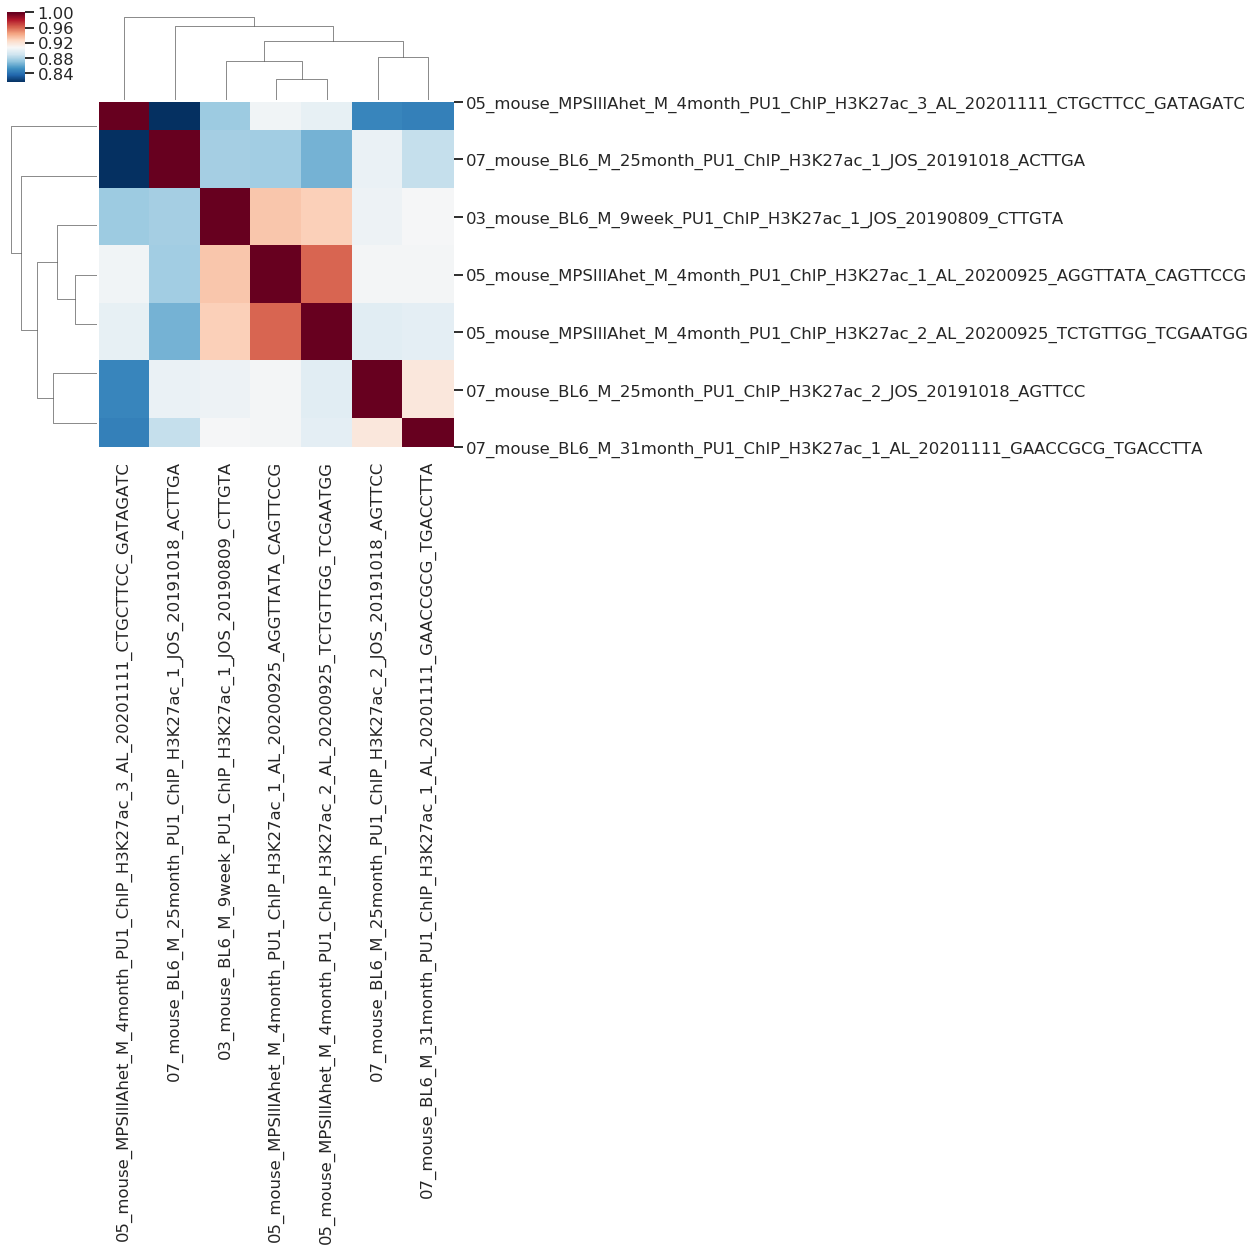

In [41]:
cm = sns.clustermap(
    mat.corr(),
    cmap='RdBu_r',
    figsize=(8,8))

# adjust y axis rotation
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

plt.savefig('./figures/samp_filt_h3k27ac_correlation_heatmap.png', bbox_inches='tight')

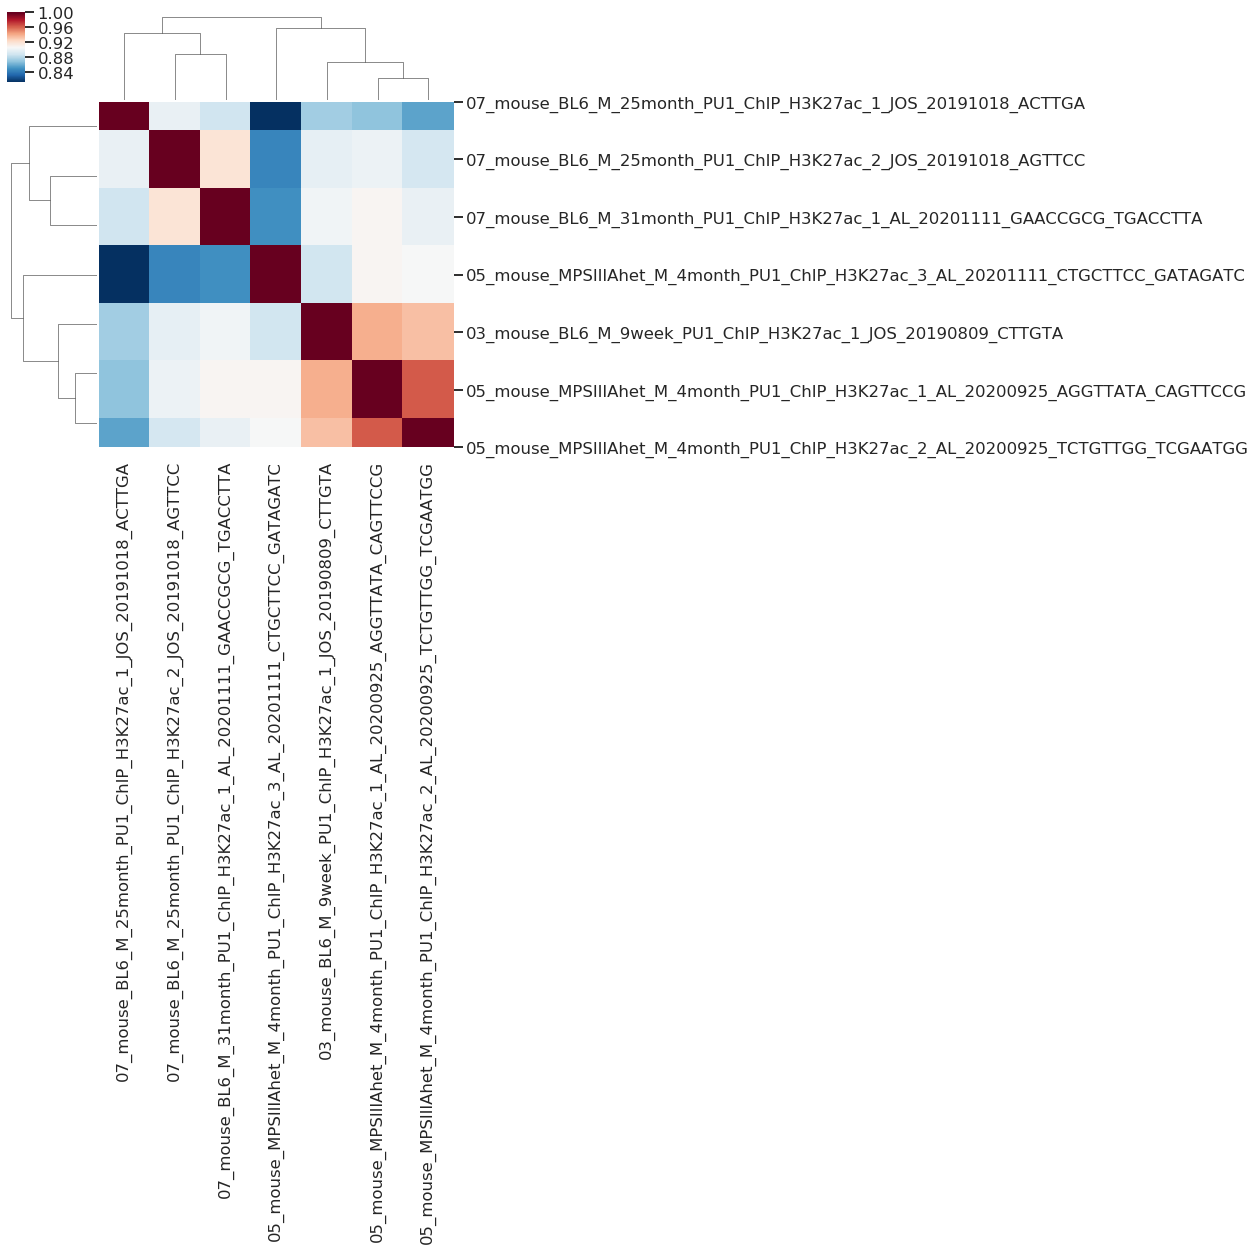

In [42]:
cm = sns.clustermap(
    mat_distal.corr(),
    cmap='RdBu_r',
    figsize=(8,8))

# adjust y axis rotation
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

plt.savefig('./figures/samp_filt_h3k27ac_correlation_heatmap_distal.png', bbox_inches='tight')

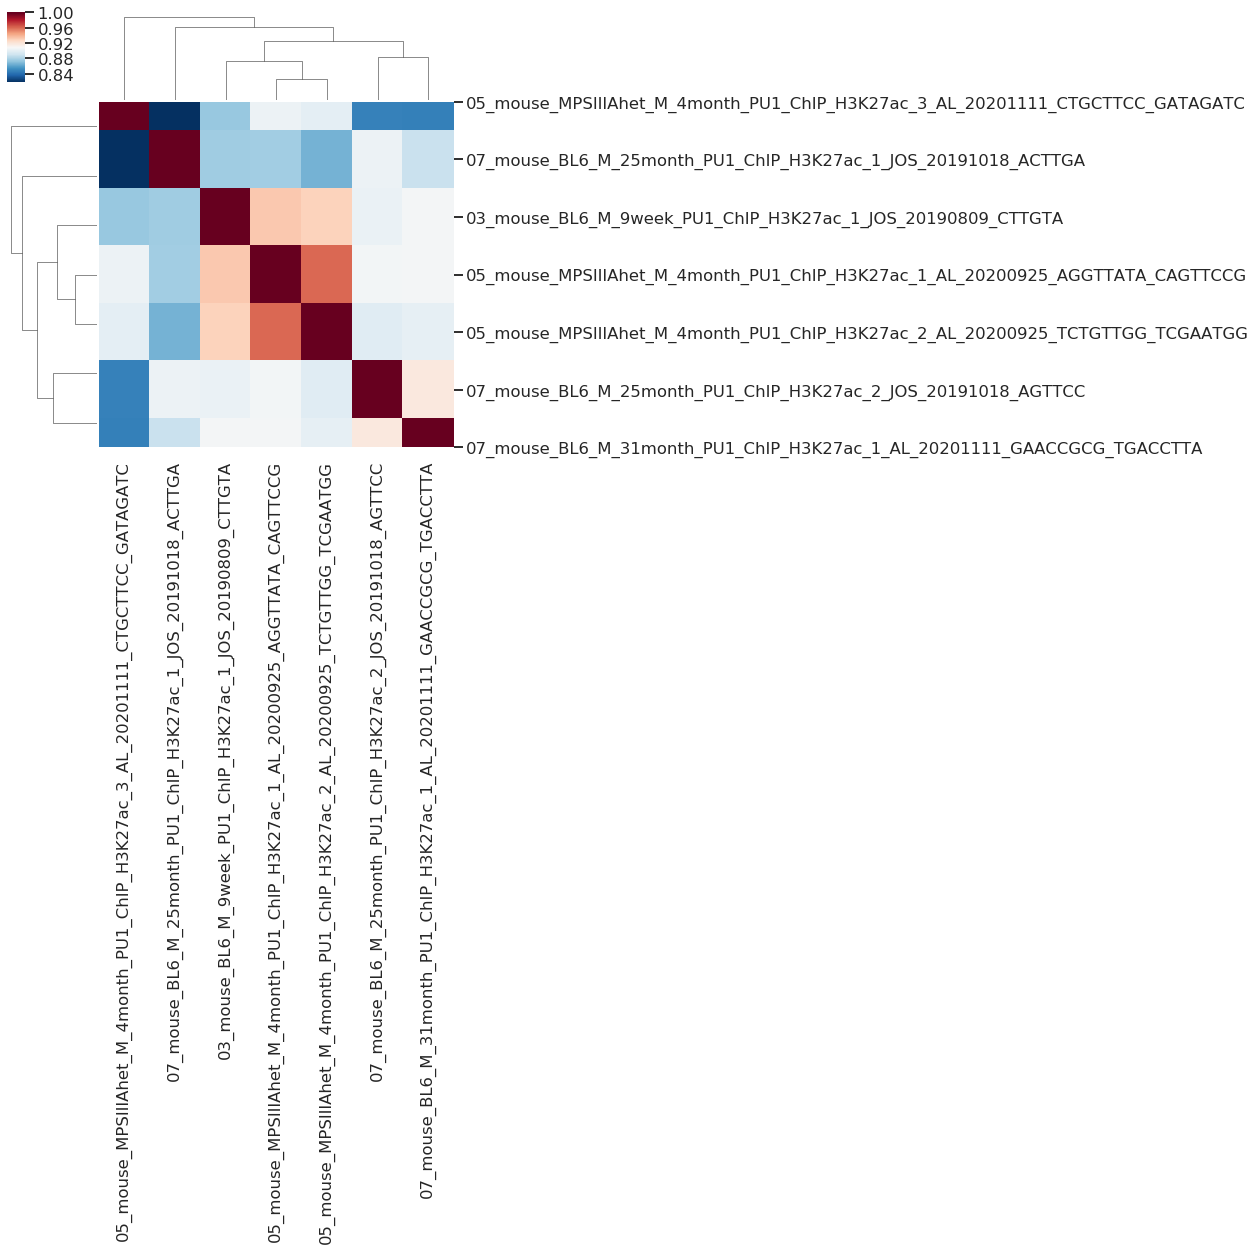

In [43]:
cm = sns.clustermap(
    mat_quant.corr(),
    cmap='RdBu_r',
    figsize=(8,8))

# adjust y axis rotation
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

plt.savefig('./figures/samp_filt_h3k27ac_correlation_heatmap_quantnorm.png', bbox_inches='tight')

## Principal component analysis

In [44]:
# this part must be done manually - use the sample ID fields to pick out
# identifiers for each sample.
samples = pd.Series(mat.columns)
group = samples.str.split('_').str[0]
strain = samples.str.split('_').str[2]
gender = samples.str.split('_').str[3]
age = samples.str.split('_').str[4]
cell = samples.str.split('_').str[5]
rep = samples.str.split('_').str[8]
sampledate = samples.str.split('_').str[9]
                                        
samplesDF = pd.DataFrame([pd.Series(samples),
                          pd.Series(group),
                          pd.Series(strain),
                          pd.Series(gender),
                          pd.Series(age),
                          pd.Series(cell),
                          pd.Series(rep),
                          pd.Series(sampledate)],
                         index=['mouse',
                                'group',
                                'strain',
                                'gender',
                                'age',
                                'celltype',
                                'rep',
                                'sample_date']).T

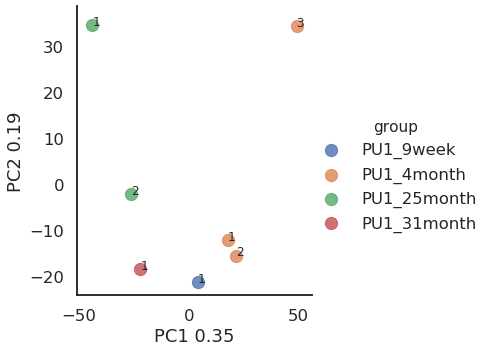

In [45]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat,
                                 group_labels=samplesDF.celltype+'_'+samplesDF.age,
                                 plot_size=5,
                                 n_pca=3)

label_point(pca.PC1,
            pca.PC2,
            samplesDF.rep,
            plt.gca())

plt.savefig('./figures/samp_filt_h3k27ac_pca1_pca2.png', bbox_inches='tight')

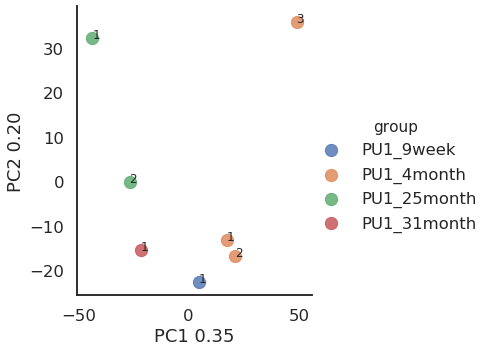

In [46]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat_quant,
                                 group_labels=samplesDF.celltype+'_'+samplesDF.age,
                                 plot_size=5,
                                 n_pca=3)

label_point(pca.PC1,
            pca.PC2,
            samplesDF.rep,
            plt.gca())

plt.savefig('./figures/samp_filt_h3k27ac_quantnorm_pca1_pca2.png', bbox_inches='tight')

Ut seems like the samples are segragating on age here - with younger samples to the right, we'll try comparing 4 months to 25 / 31 months and see what happens

# Browser shots